In [1]:
import numpy as np
import pandas as pd
import os
from Antispoofing.AntispoofHelpers.spoof_metric import determine_spoof_metrics

In [2]:
csv = pd.read_csv("C:/Users/jarre/Desktop/test_LOO_SGS8_results.csv")
csv.head()

,file_paths,ground_truth,predicted
0,/home/jarred/Documents/Datasets/SIW/test/real/...,0,0
1,/home/jarred/Documents/Datasets/SIW/test/real/...,0,0
2,/home/jarred/Documents/Datasets/SIW/test/real/...,0,0
3,/home/jarred/Documents/Datasets/SIW/test/real/...,0,0
4,/home/jarred/Documents/Datasets/SIW/test/real/...,0,0


In [8]:
from natsort import index_natsorted


def video_based_results(single_frame, protocol_name, fold_index,protocol_number, fold_save_metrics_root, save_metric_name, window_size=None):
    temp_single = single_frame.copy()
    def categorise_video(row):
        return os.path.basename(os.path.dirname(row['file_paths']))
    def get_only_frames(row):
        return os.path.basename(row['file_paths'])
    temp_single['video_name'] = temp_single.apply(lambda row: categorise_video(row), axis=1)
    video_names = temp_single['video_name'].unique()
    video_list = []
    for name in video_names:
        temp_df = temp_single.query(f"video_name == '{name}'")
        temp_df['file_paths']= temp_df.apply(lambda row: get_only_frames(row), axis=1)
        temp_df = temp_df.sort_values(by='file_paths', key=lambda x:np.argsort(index_natsorted(temp_single["file_paths"])))
        if window_size is not None:
            temp_df = temp_df[:window_size]
        real = 0
        spoof = 1
        spoof_pred_count = temp_df[(temp_df.predicted == 1)].count()["predicted"]
        real_pred_count = temp_df[(temp_df.predicted == 0)].count()["predicted"]
        if spoof_pred_count > real_pred_count:
            predicted = 1
        else:
            predicted = 0
        ground_truth = temp_df['ground_truth'].tolist()[0]
        video_list.append({"video_name": name, f'spoof({spoof})_pred_count': spoof_pred_count, f'real({real}_pred_count': real_pred_count, "predicted": predicted, "ground_truth": ground_truth})
    multi_frame = pd.DataFrame.from_dict(video_list)
    # multi_frame.to_csv(os.path.join(fold_save_metrics_root, f"test_{protocol_name}_multi_frame_results.csv"), index=False)
    predicted = multi_frame['predicted'].tolist()
    ground_truth = multi_frame['ground_truth'].tolist()
    metric_dic = determine_spoof_metrics(ground_truth, predicted, protocol_name, fold_index,protocol_number, save_dir=os.path.join(fold_save_metrics_root, f"{save_metric_name}_{protocol_name}_Multi_Metrics"), must_show=False)
    metric_dic = dict(("{}_{}".format("Multi",k),v) for k,v in metric_dic.items())
    return metric_dic

video_based_results(csv,"LOO_SGS8", 0, 2, "./", "test_multi", 60)

C:\Users\jarre\AppData\Local\Temp\ipykernel_14212\783639465.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['file_paths']= temp_df.apply(lambda row: get_only_frames(row), axis=1)


ValueError: User-provided `key` function must not change the shape of the array.

In [13]:
window = 30
pred = list(csv['predicted'])
gt = list(csv['ground_truth'])
average_data = []
print(len(gt))

10282


In [17]:
from Antispoofing.AntispoofHelpers.spoof_metric import calc_tn_fp_fn_tp, calc_apcer, calc_bpcer, calc_acer
x = []
def determine_acc(ground, prediction):
    count = 0.0
    for ind in range(len(ground)):
        if ground[ind] == prediction[ind]:
            count += 1
    return count /len(ground)
for ind in range(1, len(pred)):
    average_data.append(determine_acc(gt[:ind*window], pred[0:ind*window]))
    x.append(ind)

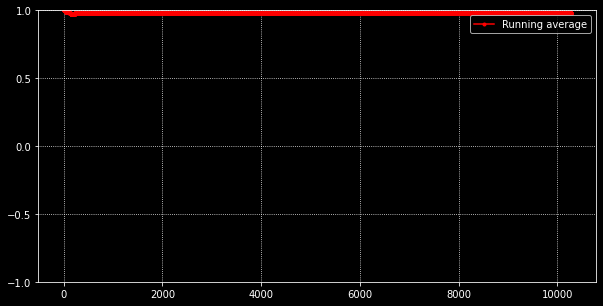

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
# plt.plot(x, y, 'k.-', label='Original data')
plt.plot(x, average_data, 'r.-', label='Running average')
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.grid(linestyle=':')
plt.legend()
plt.show()

In [3]:
# read in a csv and file and add augmentation type and when
def open_csv(csv_root, csv_path, csv_name):
    df = pd.read_csv(os.path.join(csv_root,csv_path,csv_name))
    # split the csv details
    # C:\Users\jarre\Dropbox\MasterMetrics\SIW_90_Baseline\None\combined.csv
    #C:\Users\jarre\Dropbox\MasterMetrics\SIW_SIW_KF_90_GenAugNormalAndSpoof\AfterSplit\combined.csv
    #C:\Users\jarre\Dropbox\MasterMetrics\CASIA_Baseline\None\combined.csv
    path_bits = os.path.split(csv_path)
    when_aug = path_bits[-1]
    aug_type = path_bits[-2].split("_")[-1]
    if "KF" in path_bits[-2]:
        aug_type += "_KF"

    df ["when_aug"] = when_aug
    df ["aug_type"] = aug_type
    return df

In [4]:
csv_root = "C:/Users/jarre/Dropbox/MasterMetrics"
csv_name = "combined.csv"
CASIA_Baseline_None = "CASIA_Baseline/None"
SIW_90_Baseline_None = "SIW_90_Baseline/None"
# SIW_SIW_KF_90_GenAugNormalAndSpoof_AfterSplit = "SIW_SIW_KF_90_GenAugNormalAndSpoof/AfterSplit"
# SIW_SIW_KF_90_GenAugNormalAndSpoof_BeforeSplit = "SIW_SIW_KF_90_GenAugNormalAndSpoof/BeforeSplit"
# SIW_SIW_KF_90_GenAugNormalOnly_AfterSplit = "SIW_SIW_KF_90_GenAugNormalOnly/AfterSplit"
# SIW_SIW_KF_90_GenAugNormalOnly_BeforeSplit = "SIW_SIW_KF_90_GenAugNormalOnly/BeforeSplit"
SIW_SIW_KF_90_GenAugSpoofOnly_BeforeSplit = "SIW_SIW_KF_90_GenAugSpoofOnly/BeforeSplit"
SIW_SIW_KF_90_GenAugSpoofOnly_AfterSplit = "SIW_SIW_KF_90_GenAugSpoofOnly/AfterSplit"

siw_list = [
    SIW_90_Baseline_None,
    # SIW_SIW_KF_90_GenAugNormalAndSpoof_AfterSplit,
    # SIW_SIW_KF_90_GenAugNormalAndSpoof_BeforeSplit,
    # SIW_SIW_KF_90_GenAugNormalOnly_AfterSplit,
    # SIW_SIW_KF_90_GenAugNormalOnly_BeforeSplit,
    SIW_SIW_KF_90_GenAugSpoofOnly_BeforeSplit,
    SIW_SIW_KF_90_GenAugSpoofOnly_AfterSplit]

combined_frame =pd.concat( [open_csv(csv_root, path, csv_name) for path in siw_list]).groupby(['protocol_number', 'config/HP_AUG_PER', 'aug_type', 'when_aug']).mean()

In [5]:
# combined_frame.to_csv(os.path.join(csv_root, "siw_kf_combined.csv"), index=True)

In [6]:
csv_root = "C:/Users/jarre/Dropbox/MasterMetrics"
csv_name = "combined.csv"
CASIA_Baseline_None = "CASIA_Baseline/None"
SIW_90_Baseline_None = "SIW_90_Baseline/None"
# SIW_90_GenAugNormalAndSpoof_AfterSplit = "SIW_90_GenAugNormalAndSpoof/AfterSplit"
# SIW_90_GenAugNormalAndSpoof_BeforeSplit = "SIW_90_GenAugNormalAndSpoof/BeforeSplit"
# SIW_90_GenAugNormalOnly_AfterSplit = "SIW_90_GenAugNormalOnly/AfterSplit"
# SIW_90_GenAugNormalOnly_BeforeSplit = "SIW_90_GenAugNormalOnly/BeforeSplit"
SIW_90_GenAugSpoofOnly_BeforeSplit = "SIW_90_GenAugSpoofOnly/BeforeSplit"
SIW_90_GenAugSpoofOnly_AfterSplit = "SIW_90_GenAugSpoofOnly/AfterSplit"

siw_list = [SIW_90_Baseline_None,
            # SIW_90_GenAugNormalAndSpoof_AfterSplit,
            # SIW_90_GenAugNormalAndSpoof_BeforeSplit,
            # SIW_90_GenAugNormalOnly_AfterSplit,
            # SIW_90_GenAugNormalOnly_BeforeSplit,
            SIW_90_GenAugSpoofOnly_BeforeSplit,
            SIW_90_GenAugSpoofOnly_AfterSplit]

combined_frame =pd.concat( [open_csv(csv_root, path, csv_name) for path in siw_list]).groupby(['protocol_number', 'config/HP_AUG_PER', 'aug_type', 'when_aug']).mean()
# combined_frame.to_csv(os.path.join(csv_root, "siw_af_combined.csv"), index=True)

In [7]:
siw_combined_list = [SIW_90_Baseline_None,
                     # SIW_SIW_KF_90_GenAugNormalAndSpoof_AfterSplit,
                     # SIW_SIW_KF_90_GenAugNormalAndSpoof_BeforeSplit,
                     # SIW_SIW_KF_90_GenAugNormalOnly_AfterSplit,
                     # SIW_SIW_KF_90_GenAugNormalOnly_BeforeSplit,
                     SIW_SIW_KF_90_GenAugSpoofOnly_BeforeSplit,
                     SIW_SIW_KF_90_GenAugSpoofOnly_AfterSplit,
                     # SIW_90_GenAugNormalAndSpoof_AfterSplit,
                     # SIW_90_GenAugNormalAndSpoof_BeforeSplit,
                     # SIW_90_GenAugNormalOnly_AfterSplit,
                     # SIW_90_GenAugNormalOnly_BeforeSplit,
                     SIW_90_GenAugSpoofOnly_BeforeSplit,
                     SIW_90_GenAugSpoofOnly_AfterSplit]
combined_frame =pd.concat( [open_csv(csv_root, path, csv_name) for path in siw_combined_list]).groupby(['protocol_number', 'config/HP_AUG_PER', 'aug_type', 'when_aug']).mean()
# combined_frame.to_csv(os.path.join(csv_root, "siw_combined.csv"), index=True)
combined_frame.head(30)

TP  \
protocol_number config/HP_AUG_PER aug_type           when_aug                   
2               0.00              Baseline           None         1365.375000   
                0.05              GenAugSpoofOnly    AfterSplit   1347.875000   
                                                     BeforeSplit  1353.208333   
                                  GenAugSpoofOnly_KF AfterSplit   1355.000000   
                                                     BeforeSplit  1337.500000   
                0.10              GenAugSpoofOnly    AfterSplit   1365.208333   
                                                     BeforeSplit  1350.875000   
                                  GenAugSpoofOnly_KF AfterSplit   1363.125000   
                                                     BeforeSplit  1350.416667   
                0.20              GenAugSpoofOnly    AfterSplit   1361.041667   
                                                     BeforeSplit  1357.750000   
                                  GenAugSpoofOnly_KF AfterSplit   1358.958333   
                                                     BeforeSplit  1364.541667   
                0.30              GenAugSpoofOnly    AfterSplit   1358.291667   
                                                     BeforeSplit  1357.375000   
                                  GenAugSpoofOnly_KF AfterSplit   1365.708333   
                                                     BeforeSplit  1358.750000   
3               0.00              Baseline           None         3081.416667   
                0.05              GenAugSpoofOnly    AfterSplit   3051.666667   
                                                     BeforeSplit  3036.416667   
                                  GenAugSpoofOnly_KF AfterSplit   3263.750000   
                                                     BeforeSplit  3022.750000   
                0.10              GenAugSpoofOnly    AfterSplit   2809.833333   
                                                     BeforeSplit  2788.666667   
                                  GenAugSpoofOnly_KF AfterSplit   3095.250000   
                                                     BeforeSplit  3171.416667   
                0.20              GenAugSpoofOnly    AfterSplit   2859.666667   
                                                     BeforeSplit  2853.500000   
                                  GenAugSpoofOnly_KF AfterSplit   3261.250000   
                                                     BeforeSplit  3114.666667   

                                                                           TN  \
protocol_number config/HP_AUG_PER aug_type           when_aug                   
2               0.00              Baseline           None         9184.166667   
                0.05              GenAugSpoofOnly    AfterSplit   9190.458333   
                                                     BeforeSplit  9180.500000   
                                  GenAugSpoofOnly_KF AfterSplit   9154.625000   
                                                     BeforeSplit  9166.500000   
                0.10              GenAugSpoofOnly    AfterSplit   9228.041667   
                                                     BeforeSplit  9280.750000   
                                  GenAugSpoofOnly_KF AfterSplit   9197.875000   
                                                     BeforeSplit  9141.791667   
                0.20              GenAugSpoofOnly    AfterSplit   9135.000000   
                                                     BeforeSplit  9308.666667   
                                  GenAugSpoofOnly_KF AfterSplit   9190.500000   
                                                     BeforeSplit  9203.291667   
                0.30              GenAugSpoofOnly    AfterSplit   9248.041667   
                                                     BeforeSplit  9242.583333   
                                  GenAugSpoofOnly_KF AfterSplit   9161.708333   
                        

In [16]:
csv_root = "C:/Users/jarre/Dropbox/SIW/MasterMetrics"
combined_csv_name = "combined.csv"
individual_csv_name = "individual.csv"
combined_describe = "combined_describe.csv"

SIW_90_Baseline_None = "SIW_90_Baseline/None"
SIW_90_GenAugSpoofOnly_BeforeSplit = "SIW_90_GenAugSpoofOnly/BeforeSplit"
SIW_90_GenAugSpoofOnly_AfterSplit = "SIW_90_GenAugSpoofOnly/AfterSplit"
SIW_90_TradAugSpoofOnly_BeforeSplit = "SIW_90_TradAugSpoofOnly/BeforeSplit"
SIW_90_TradAugSpoofOnly_AfterSplit = "SIW_90_TradAugSpoofOnly/AfterSplit"
SIW_SIW_KF_90_GenAugSpoofOnly_BeforeSplit = "SIW_SIW_KF_90_GenAugSpoofOnly/BeforeSplit"
SIW_SIW_KF_90_GenAugSpoofOnly_AfterSplit = "SIW_SIW_KF_90_GenAugSpoofOnly/AfterSplit"

siw_combined_list = [
        SIW_90_Baseline_None,
        SIW_90_TradAugSpoofOnly_BeforeSplit,
        SIW_90_TradAugSpoofOnly_AfterSplit,
        SIW_SIW_KF_90_GenAugSpoofOnly_BeforeSplit,
        SIW_SIW_KF_90_GenAugSpoofOnly_AfterSplit,
        SIW_90_GenAugSpoofOnly_BeforeSplit,
        SIW_90_GenAugSpoofOnly_AfterSplit
]

# combined_frame =pd.concat( [open_csv(csv_root, path, combined_csv_name) for path in siw_combined_list]).groupby(['protocol_number', 'config/HP_AUG_PER', 'aug_type', 'when_aug']).mean()
# combined_frame.to_csv(os.path.join(csv_root, "siw_combined.csv"), index=True)

individual_frame =pd.concat( [open_csv(csv_root, path, individual_csv_name) for path in siw_combined_list]).groupby(['protocol_number', 'protocol', 'config/HP_AUG_PER', 'aug_type', 'when_aug']).mean()
individual_frame.to_csv(os.path.join(csv_root, "siw_individual.csv"), index=True)

describe_frame =pd.concat( [open_csv(csv_root, path, combined_describe) for path in siw_combined_list]).groupby(['protocol_number', 'config/HP_AUG_PER', 'aug_type', 'when_aug']).mean()
# describe_frame.to_csv(os.path.join(csv_root, "siw_describe.csv"), index=True)
describe_frame.head(1000)

KeyError: 'protocol_number'

In [14]:
combined_frame =pd.concat( [open_csv(csv_root, path, combined_csv_name) for path in siw_combined_list]).groupby(['protocol_number', 'config/HP_AUG_PER', 'aug_type', 'when_aug'])
combined_frame.head(100)

,protocol_number,config/HP_AUG_PER,TP,TN,FP,FN,APCER,BPCER,ACER,EER,...,Multi_FN,Multi_APCER,Multi_BPCER,Multi_ACER,Multi_EER,Multi_AUC,config/HP_REPEAT,fold_number,when_aug,aug_type
0,2,0.00,1365.375000,9184.166667,197.833333,75.875000,0.049105,0.021086,0.035096,0.060695,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.5,1.0,None,Baseline
1,3,0.00,3081.416667,9330.083333,51.916667,901.583333,0.172821,0.005534,0.089177,0.140259,...,2.000000,0.142857,0.000000,0.071429,0.111111,0.928571,1.5,1.0,None,Baseline
0,2,0.05,1355.583333,9119.875000,262.125000,85.666667,0.053650,0.027939,0.040795,0.070317,...,NaN,NaN,NaN,NaN,NaN,NaN,1.5,1.0,BeforeSplit,TradAugSpoofOnly
1,2,0.10,1366.333333,9192.750000,189.250000,74.916667,0.047785,0.020172,0.033978,0.060788,...,NaN,NaN,NaN,NaN,NaN,NaN,1.5,1.0,BeforeSplit,TradAugSpoofOnly
2,2,0.20,1381.666667,8936.958333,445.041667,59.583333,0.038088,0.047436,0.042762,0.072477,...,NaN,NaN,NaN,NaN,NaN,NaN,1.5,1.0,BeforeSplit,TradAugSpoofOnly
3,2,0.30,1379.375000,8996.291667,385.708333,61.875000,0.039353,0.041112,0.040232,0.069110,...,NaN,NaN,NaN,NaN,NaN,NaN,1.5,1.0,BeforeSplit,TradAugSpoofOnly
4,3,0.05,3109.000000,9223.250000,158.750000,874.000000,0.158861,0.016921,0.087891,0.136431,...,NaN,NaN,NaN,NaN,NaN,NaN,1.5,1.0,BeforeSplit,TradAugSpoofOnly
5,3,0.10,3099.666667,9299.250000,82.750000,883.333333,0.160245,0.008820,0.084533,0.130393,...,NaN,NaN,NaN,NaN,NaN,NaN,1.5,1.0,BeforeSplit,TradAugSpoofOnly
6,3,0.20,3124.250000,9212.333333,169.666667,858.750000,0.151464,0.018084,0.084774,0.130998,...,NaN,NaN,NaN,NaN,NaN,NaN,1.5,1.0,BeforeSplit,TradAugSpoofOnly
7,3,0.30,3136.916667,9284.583333,97.416667,846.083333,0.150788,0.010383,0.080586,0.123648,...,NaN,NaN,NaN,NaN,NaN,NaN,1.5,1.0,BeforeSplit,TradAugSpoofOnly


In [ ]:
def video_based_results(single_frame, protocol_name, fold_index,protocol_number, fold_save_metrics_root, save_metric_name):
    temp_single = single_frame.copy()
    def categorise_video(row):
        return os.path.basename(os.path.dirname(row['file_paths']))
    temp_single['video_name'] = temp_single.apply(lambda row: categorise_video(row), axis=1)
    video_names = temp_single['video_name'].unique()
    video_list = []
    for name in video_names:
        temp_df = temp_single.query(f"video_name == '{name}'")
        real = 0
        spoof = 1
        spoof_pred_count = temp_df[(temp_df.predicted == 1)].count()["predicted"]
        real_pred_count = temp_df[(temp_df.predicted == 0)].count()["predicted"]
        if spoof_pred_count > real_pred_count:
            predicted = 1
        else:
            predicted = 0
        ground_truth = temp_df['ground_truth'].tolist()[0]
        video_list.append({"video_name": name, f'spoof({spoof})_pred_count': spoof_pred_count, f'real({real}_pred_count': real_pred_count, "predicted": predicted, "ground_truth": ground_truth})
    multi_frame = pd.DataFrame.from_dict(video_list)
    multi_frame.to_csv(os.path.join(fold_save_metrics_root, f"test_{protocol_name}_multi_frame_results.csv"), index=False)
    predicted = multi_frame['predicted'].tolist()
    ground_truth = multi_frame['ground_truth'].tolist()
    metric_dic = determine_spoof_metrics(ground_truth, predicted, protocol_name, fold_index,protocol_number, save_dir=os.path.join(fold_save_metrics_root, f"{save_metric_name}_{protocol_name}_Multi_Metrics"), must_show=False)
    metric_dic = dict(("{}_{}".format("Multi",k),v) for k,v in metric_dic.items())
    return metric_dic